# Keras custom series-Loss function  
有時候內建的`loss function(objective function)`無法滿足需求，就必須自定義function。   
在Keras中，自定義loss function的寫法為`def fn(y_true, y_pred)`，才能將loss function放入`compile`中。  
並且裡面的計算方法必須使用`tensorflow op`達成。
這次用autoencoder model來當作model，loss function採用自己定義的L2-norm。

In [1]:
#載入所需lib
import numpy as np
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print('TensorFlow version:', tf.__version__)
#畫圖的lib
import matplotlib.pyplot as plt

TensorFlow version: 2.2.0


AutoEncoder(AE)是一種Unsupervised learning，主要有以下幾個應用：  
+ feature extraction  
+ 降維  
+ 建立model 初始weight  

AE model分為兩個部分：`Encoder`與`Decoder`，`Encoder`負責將輸入壓縮、`Decoder`負責將壓縮後的feature還原，這兩個部分合起來就是一個AE model。

In [2]:
#autoencoder model
def get_AE():
    inputs = tf.keras.Input(shape=(28,28,1))
    #encoder
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', strides=2, padding='same')(inputs)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(16)(x)
    #decoder
    x = tf.keras.layers.Dense(7*7*64)(x)
    x = tf.keras.layers.Reshape((7,7,64))(x)
    x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(x)
    x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, activation='relu', strides=2, padding='same')(x)
    x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, activation='sigmoid', padding='same')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.summary()
    return model

loss function使用MSE，這邊用自定義的方式。  
裡面的運算方式皆須使用tf operator完成。

In [3]:
#Mean Square Error
@tf.function
def AE_loss(y_true, y_pred):
    #y_true, y_pred shape: (28, 28, 1)
    loss = tf.math.reduce_mean(tf.math.square(y_true - y_pred))
    return loss

定義好`loss function`之後只要將`loss function`放入`compile`中即可。

In [4]:
#download MNIST dataset and preprocessing
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# parameter init
epochs = 100
batch_size = 256

# optimizer
opt = tf.keras.optimizers.Adam()

model = get_AE()
model.compile( loss=AE_loss, optimizer=opt)
history = model.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                50192     
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0     

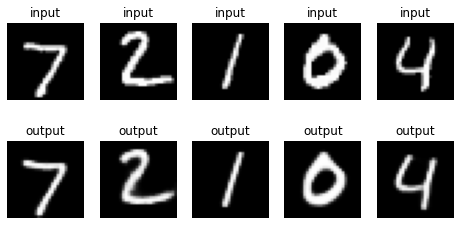

In [5]:
#輸出前5個影像以及結果
plt.figure(figsize=(8, 8))
plt.subplots_adjust(top=0.5)
for i, images in enumerate(x_test[0:5]):
    plt.subplot(2,5, i+1)
    plt.imshow(images.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title('input')
    pred = model.predict(np.expand_dims(images, 0))
    pred = pred.reshape(28, 28)
    plt.subplot(2,5, i+6)
    plt.imshow(pred, cmap='gray')
    plt.axis('off')
    plt.title('output')

## **總結**  
自定義loss function就是兩個輸入(`y_true`和`y_pred`)之間的運算，並且返回計算後的loss。  
Tensor之間的運算，需使用TF operator來進行。